In [30]:
# Importing necessary libraries
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import faiss

In [31]:
# Load the pre-trained VGG19 model + higher level layers
base_model = VGG19(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)

In [32]:
# Function to load the image and preprocess it
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = tf.keras.applications.vgg19.preprocess_input(img_data)
    return img_data

In [33]:
# Function to Extract embeddings
def get_embedding(model, img_path):
    img_data = preprocess_image(img_path)
    embedding = model.predict(img_data)
    return embedding.flatten()

In [34]:
# Load the images, extract embeddings and store them in a list along with labels.
image_dir = 'D:\\Programming\\Project\\dataset_5'  # Directory containing actor images
embeddings = []
labels = []
image_paths = []

In [35]:
for actor in os.listdir(image_dir):
    actor_dir = os.path.join(image_dir, actor)
    if os.path.isdir(actor_dir):
        for img_file in os.listdir(actor_dir):
            img_path = os.path.join(actor_dir, img_file)
            if img_path.endswith(('jpg', 'jpeg', 'png')):  # Check for valid image files
                embedding = get_embedding(model, img_path)
                embeddings.append(embedding)
                labels.append(actor)
                image_paths.append(img_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [36]:
embeddings1 = embeddings
# Normalize embeddings
embeddings = normalize(embeddings)
# Convert into arrays
embeddings = np.array(embeddings)
labels = np.array(labels)
image_paths = np.array(image_paths)

In [37]:
# Fit KNN with different distance metrics
knn = NearestNeighbors(n_neighbors=3, metric='cosine').fit(embeddings)

In [38]:
# Use KNN to find the most similar embeddings
def find_similar_images(img_path, model, knn, labels, image_paths):
    embedding = get_embedding(model, img_path)
    embedding = normalize([embedding])
    distances, indices = knn.kneighbors(embedding)
    inverse_distances = 1 / (distances[0] + 1e-8)  # Add small value to avoid division by zero

    # Use softmax to convert to probability-like scores
    exp_scores = np.exp(inverse_distances)
    probabilities = exp_scores / np.sum(exp_scores)

    sorted_indices = np.argsort(-probabilities)
    sorted_probabilities = probabilities[sorted_indices]
    sorted_similar_images = labels[indices[0][sorted_indices]]
    sorted_similar_image_paths = image_paths[indices[0][sorted_indices]]

    return sorted_similar_images, sorted_similar_image_paths, sorted_probabilities

In [39]:
# Function to display the input image and similar images
def display_similar_images(input_image, similar_images, similar_image_paths, probabilities):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    input_img = image.load_img(input_image, target_size=(224, 224))
    input_img = image.img_to_array(input_img) / 255.0
    axes[0].imshow(input_img)
    axes[0].set_title("Input Image")
    axes[0].axis('off')
    for i in range(3):
        img = image.load_img(similar_image_paths[i], target_size=(224, 224))
        img = image.img_to_array(img) / 255.0  # Normalize the image to [0, 1] range
        axes[i + 1].imshow(img)
        axes[i + 1].set_title(f"{similar_images[i]}\nProb: {probabilities[i]:.2f}")
        axes[i + 1].axis('off')
    plt.show()

In [40]:
# Load the image and find the top three similar actors/actresses
input_image = 'D:\\Programming\\Project\\WhatsApp Image 2024-06-24 at 08.52.37_7b51d00c.jpg'
similar_images, similar_image_paths, probabilities = find_similar_images(input_image, model, knn, labels, image_paths)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [41]:
# Print the list of similar actors
print("Top 3 similar actors/actresses:")
for i in range(3):
    print(f"{similar_images[i]} with probability {probabilities[i]:.2f}")

Top 3 similar actors/actresses:
sachin_khedekar with probability 0.44
sachin_khedekar with probability 0.34
nagarjuna_akkineni with probability 0.22


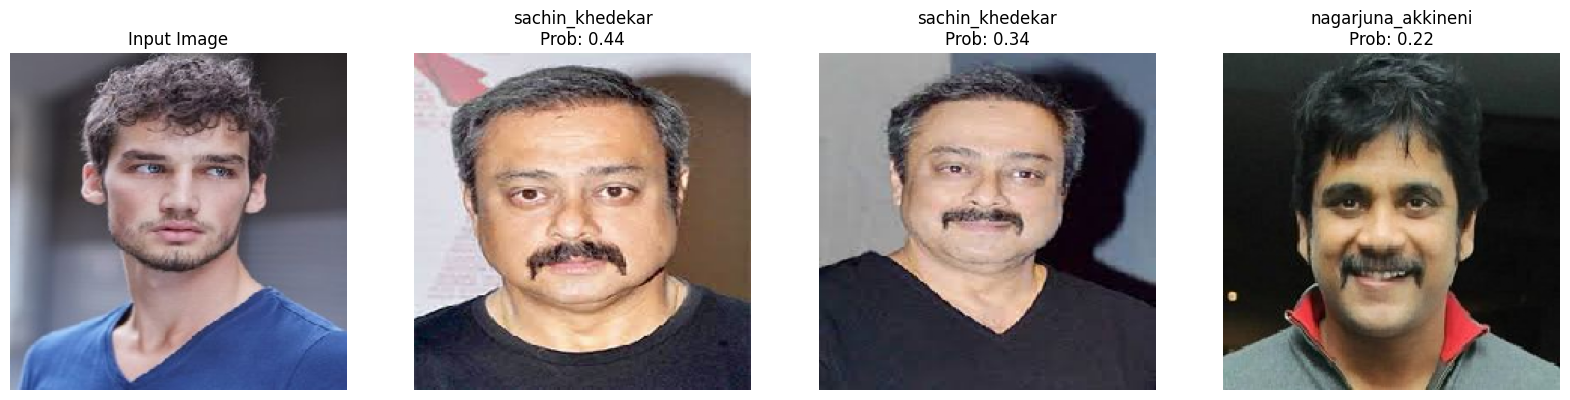

In [42]:
# Display the input image, similar actors along with probabilities
display_similar_images(input_image, similar_images, similar_image_paths, probabilities)

In [43]:
# Fit KNN with different distance metrics
knn = NearestNeighbors(n_neighbors=3, metric='euclidean').fit(embeddings)
# Load the image and find the top three similar actors/actresses
similar_images, similar_image_paths, probabilities = find_similar_images(input_image, model, knn, labels, image_paths)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step


In [44]:
# Print the list of similar actors
print("Top 3 similar actors/actresses:")
for i in range(3):
    print(f"{similar_images[i]} with probability {probabilities[i]:.2f}")

Top 3 similar actors/actresses:
sachin_khedekar with probability 0.35
sachin_khedekar with probability 0.34
nagarjuna_akkineni with probability 0.31


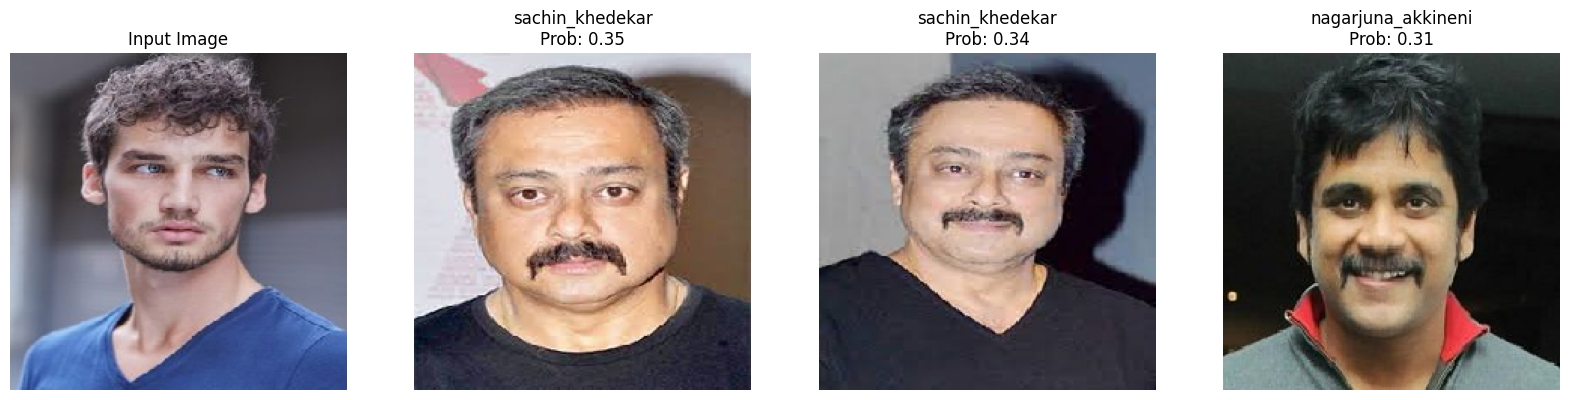

In [45]:
# Display the input image, similar actors along with probabilities
display_similar_images(input_image, similar_images, similar_image_paths, probabilities)

In [46]:
# Fit KNN with different distance metrics
knn = NearestNeighbors(n_neighbors=3, metric='manhattan').fit(embeddings)
# Load the image and find the top three similar actors/actresses
similar_images, similar_image_paths, probabilities = find_similar_images(input_image, model, knn, labels, image_paths)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step


In [47]:
# Print the list of similar actors
print("Top 3 similar actors/actresses:")
for i in range(3):
    print(f"{similar_images[i]} with probability {probabilities[i]:.2f}")

Top 3 similar actors/actresses:
sachin_khedekar with probability 0.33
sachin_khedekar with probability 0.33
nagarjuna_akkineni with probability 0.33


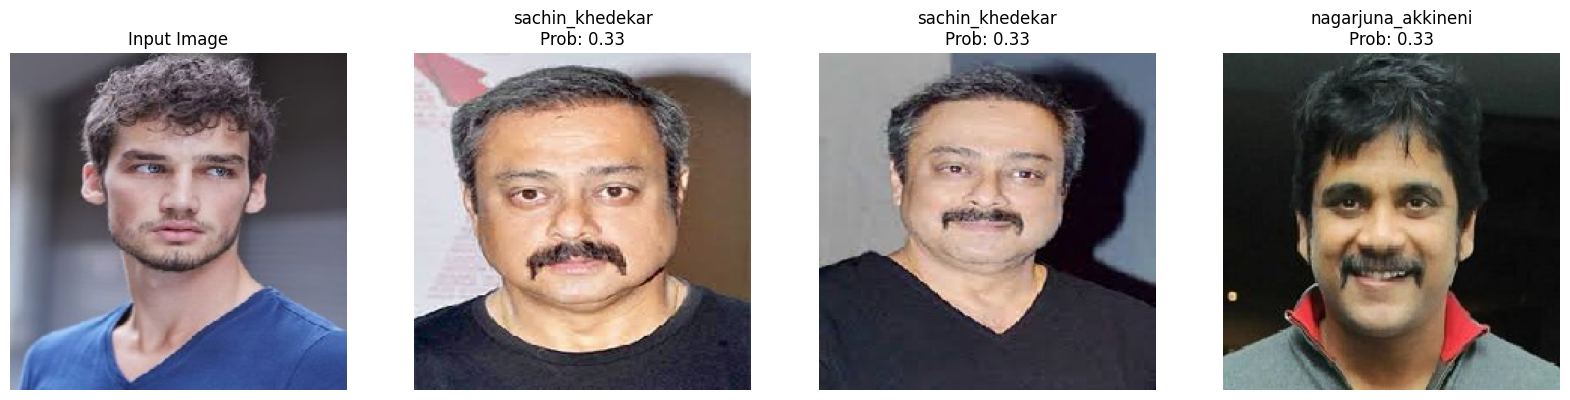

In [48]:
# Display the input image, similar actors along with probabilities
display_similar_images(input_image, similar_images, similar_image_paths, probabilities)

In [49]:
# Fit KNN with different distance metrics
knn = NearestNeighbors(n_neighbors=3, metric='correlation').fit(embeddings)
# Load the image and find the top three similar actors/actresses
similar_images, similar_image_paths, probabilities = find_similar_images(input_image, model, knn, labels, image_paths)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


In [50]:
# Print the list of similar actors
print("Top 3 similar actors/actresses:")
for i in range(3):
    print(f"{similar_images[i]} with probability {probabilities[i]:.2f}")

Top 3 similar actors/actresses:
sachin_khedekar with probability 0.43
sachin_khedekar with probability 0.34
nagarjuna_akkineni with probability 0.23


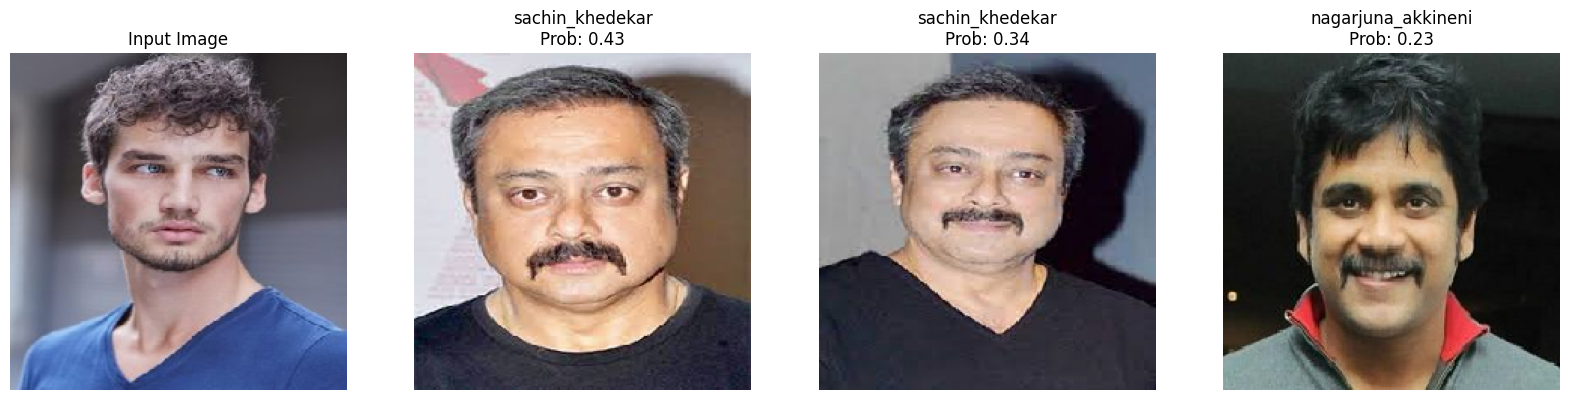

In [51]:
# Display the input image, similar actors along with probabilities
display_similar_images(input_image, similar_images, similar_image_paths, probabilities)

In [52]:
# Normalize embeddings
embeddings1 = normalize(embeddings1)

# Convert into arrays
embeddings1 = np.array(embeddings1).astype('float32')
labels = np.array(labels)
image_paths = np.array(image_paths)

# Create a FAISS index and add the embeddings
index = faiss.IndexFlatL2(embeddings1.shape[1])
index.add(embeddings)